In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
from hoomd.neb_plugin import neb
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [2]:
import hoomd.pair_plugin.pair as pair_plugin

In [3]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [4]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [5]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [6]:
for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = sorted(glob.glob(job.fn("short_runs/temp-*/")))
    for run in runs:
        print(run)
        temp = float(utils.extract_between(run, "temp-", "/"))
        fire_file = run + "fire_traj.gsd"
        # print(run)
        traj = gsd.hoomd.open(fire_file, "rb")
        df = pd.read_parquet(run + "struct-descr.parquet")

        break

0 {'seed': 0, 'init': True, 'temps': [2.0, 1.8, 1.6, 1.4, 1.2, 1.0, 0.9, 0.8, 0.75, 0.7, 0.67, 0.64, 0.61, 0.58, 0.55, 0.53, 0.51, 0.49, 0.47, 0.45, 0.43, 0.41], 'alpha_ests': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0354841942940312, 1.3397690122883383, 1.9147213152655829, 2.427651106103333, 3.2650328444742174, 4.051542695887625, 5.218161511196287, 7.044415153987661, 10.10020001455888, 15.65947793481358, 22.171066058445877, 33.176064452520336, 53.117878466989104, 92.44383930410444, 178.47690107882985, 392.5634880273459, 1018.9213055070264], 'checkpoint': {'temp_idx': 20, 'start_tstep': 17557689}, 'fire_applied': True, 'training_sfs_computed': True, 'softness_trained': True, 'analysis_sfs_computed': True, 'const_shear_ran': True}
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.45/


In [7]:
idx = 60
tdf = df[df.frame == idx]
len(tdf[tdf.phop > 0.2])

25

In [8]:
df.head()

,frame,tag,type,phop,softness,entropy,entropy-binary,entropy-binary-opt,rearrang
0,0,0,0,0.000713,0.118890,-2.236004,-3.457283,-2.535503,False
1,0,1,0,0.000862,-0.385413,-2.102081,-2.999533,-2.505927,False
2,0,2,0,0.014712,-0.009888,-2.508852,-4.182886,-2.655738,False
3,0,3,0,0.000485,-0.710552,-2.242270,-3.260788,-2.456938,False
4,0,4,0,0.001081,-0.273929,-3.410165,-6.389401,-3.671592,False


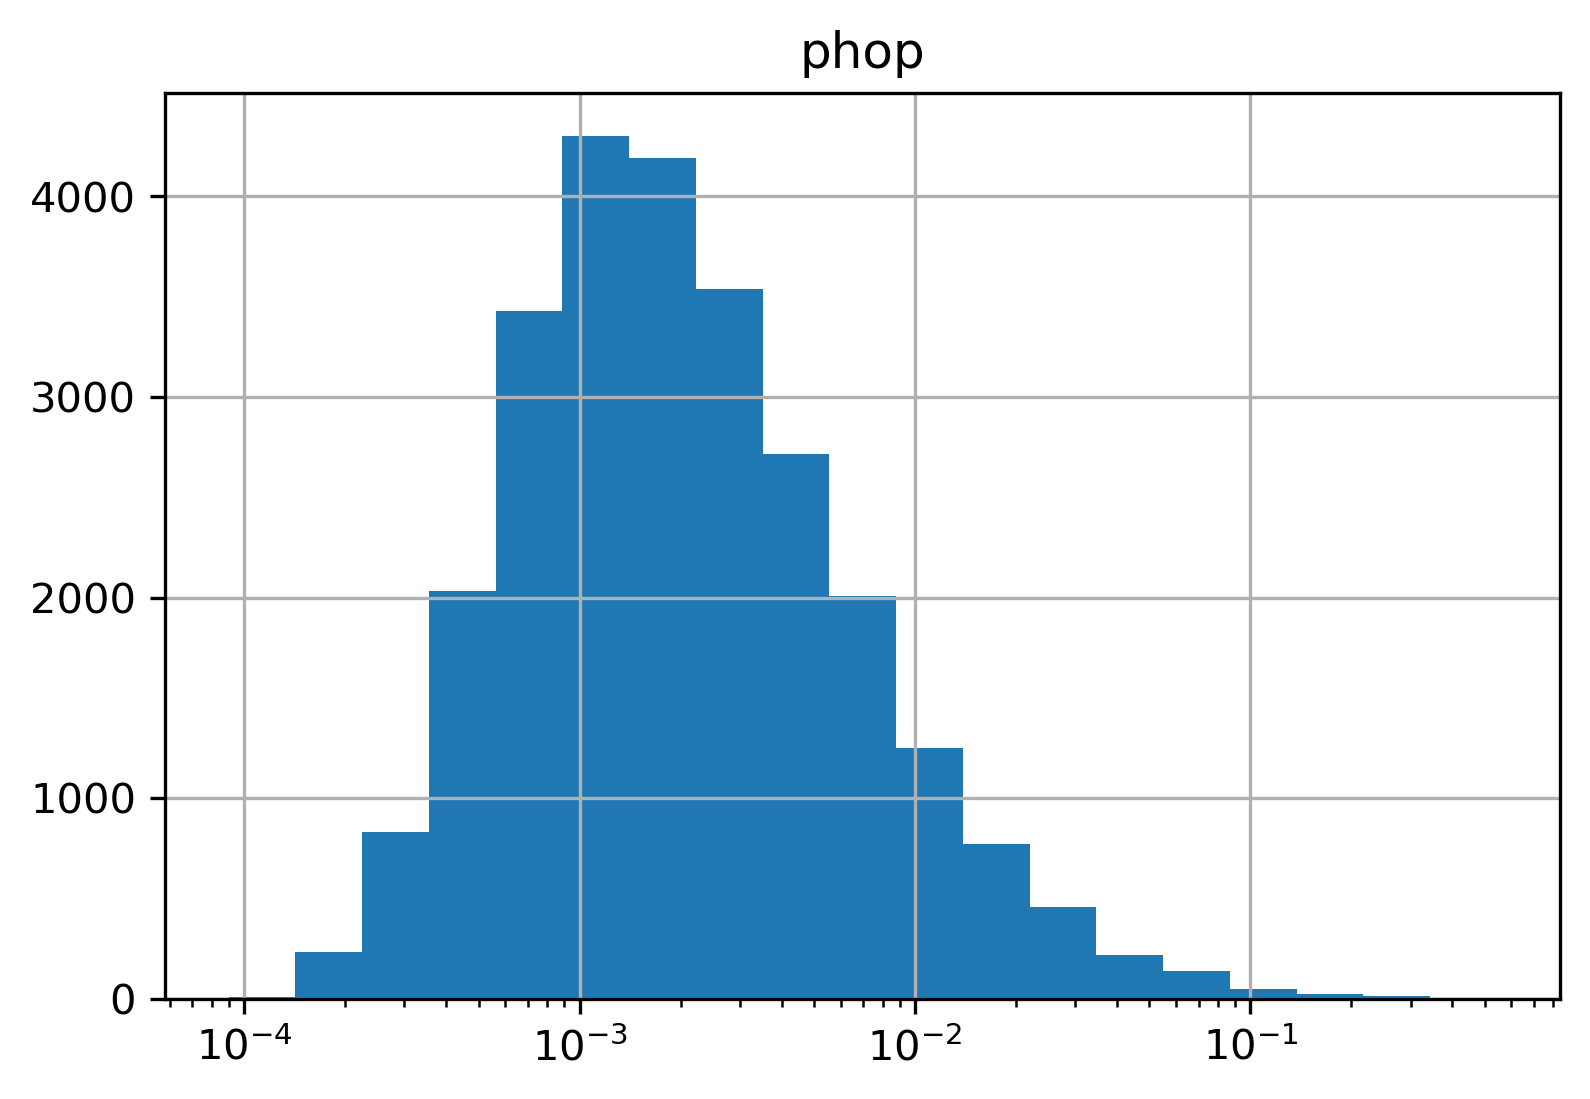

In [9]:
sdf = df[df.frame == 0]
smin = sdf.phop.min()
smax = sdf.phop.max()
sdf.hist("phop", bins=np.logspace(np.log10(smin), np.log10(smax), 20))
plt.xscale('log')

In [10]:
nlist = hoomd.md.nlist.Cell(0.3)
mlj = pair.KA_ModLJ(nlist, 0.0)
forces = [mlj]
dev = "gpu"
filter = hoomd.filter.All()

snap2snap = hoomd.Snapshot.from_gsd_snapshot
device = hoomd.device.GPU()

neb_driver = neb.NEBDriver(snap2snap(traj[0], device.communicator), snap2snap(traj[10], device.communicator), n_images=10, forces=forces, filter=filter, device=dev)
neb_driver.k = 100.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


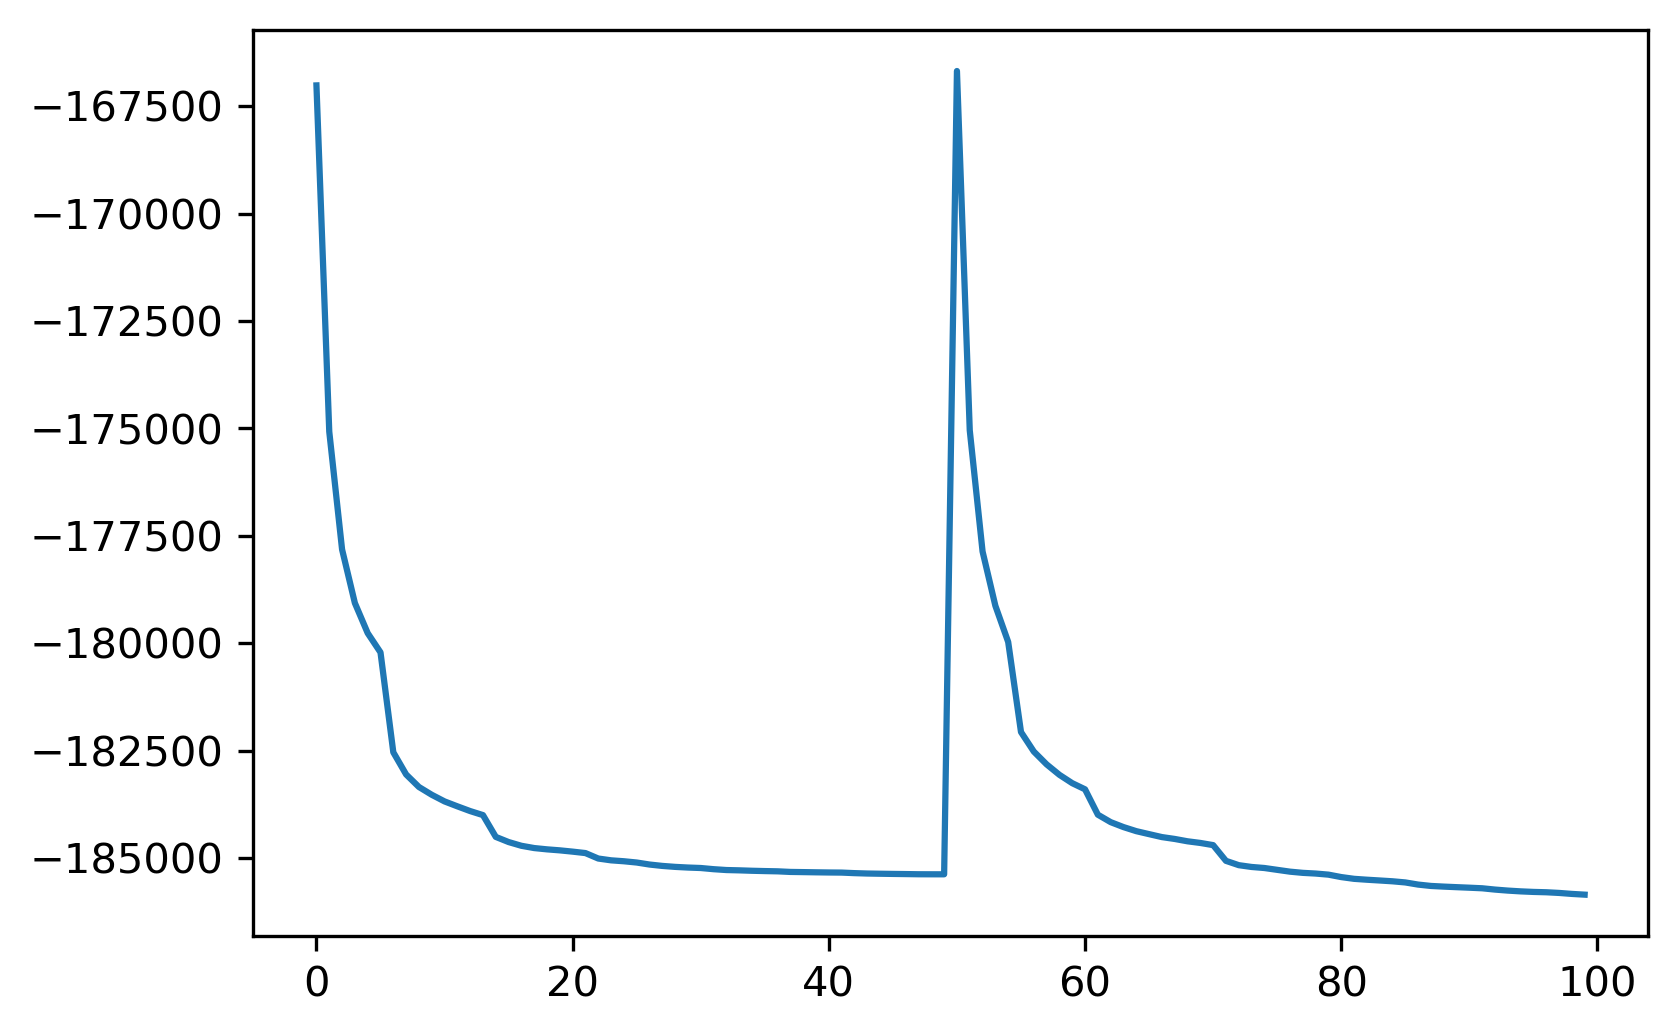

In [11]:
start = neb_driver._neb_sims[0]
end = neb_driver._neb_sims[-1]

start.operations.integrator.nudge = False
energy = []
for i in range(50):
    print(i)
    start.run(100)
    energy.append(start.operations.integrator.energy)
start.operations.integrator.nudge = True

end.operations.integrator.nudge = False
for i in range(50):
    print(i)
    end.run(100)
    energy.append(end.operations.integrator.energy)
end.operations.integrator.nudge = True

plt.plot(energy)
# plt.yscale('log')

In [12]:
def d_omega(snap1, snap2):
    box = freud.box.Box.from_box(snap1.configuration.box)
    pos1 = snap1.particles.position
    pos2 = snap2.particles.position
    diff = box.wrap(pos2 - pos1)
    return np.linalg.norm(diff)

1: 5.560029983520508
2: 7.231426000595093
3: 7.117585182189941
4: 7.011557340621948
5: 6.488016843795776
6: 5.118807077407837
7: 5.663191080093384
8: 7.036237478256226
9: 6.877155303955078
10: 7.001166105270386
11: 6.1700968742370605
12: 6.342386722564697
13: 6.604154586791992
14: 5.871063947677612
15: 6.988422632217407
16: 6.023017883300781
17: 4.504333972930908
18: 6.801215171813965
19: 5.5101637840271
20: 6.331481695175171
21: 5.994523763656616
22: 6.810770511627197
23: 6.951131105422974
24: 6.247182369232178
25: 6.499935865402222
26: 7.061551570892334
27: 6.54848051071167
28: 6.3292622566223145
29: 6.337055444717407
30: 6.374011039733887
31: 5.356560468673706
32: 7.008755922317505
33: 6.943318605422974
34: 6.426091909408569
35: 6.725276708602905
36: 6.348568439483643
37: 6.731043338775635
38: 6.708486557006836
39: 7.080699682235718
40: 6.435750484466553
41: 5.360767602920532
42: 5.723377466201782
43: 6.096558570861816
44: 6.073936462402344
45: 7.082448482513428
46: 6.76439046859741

Text(0.5, 0, 'Node i')

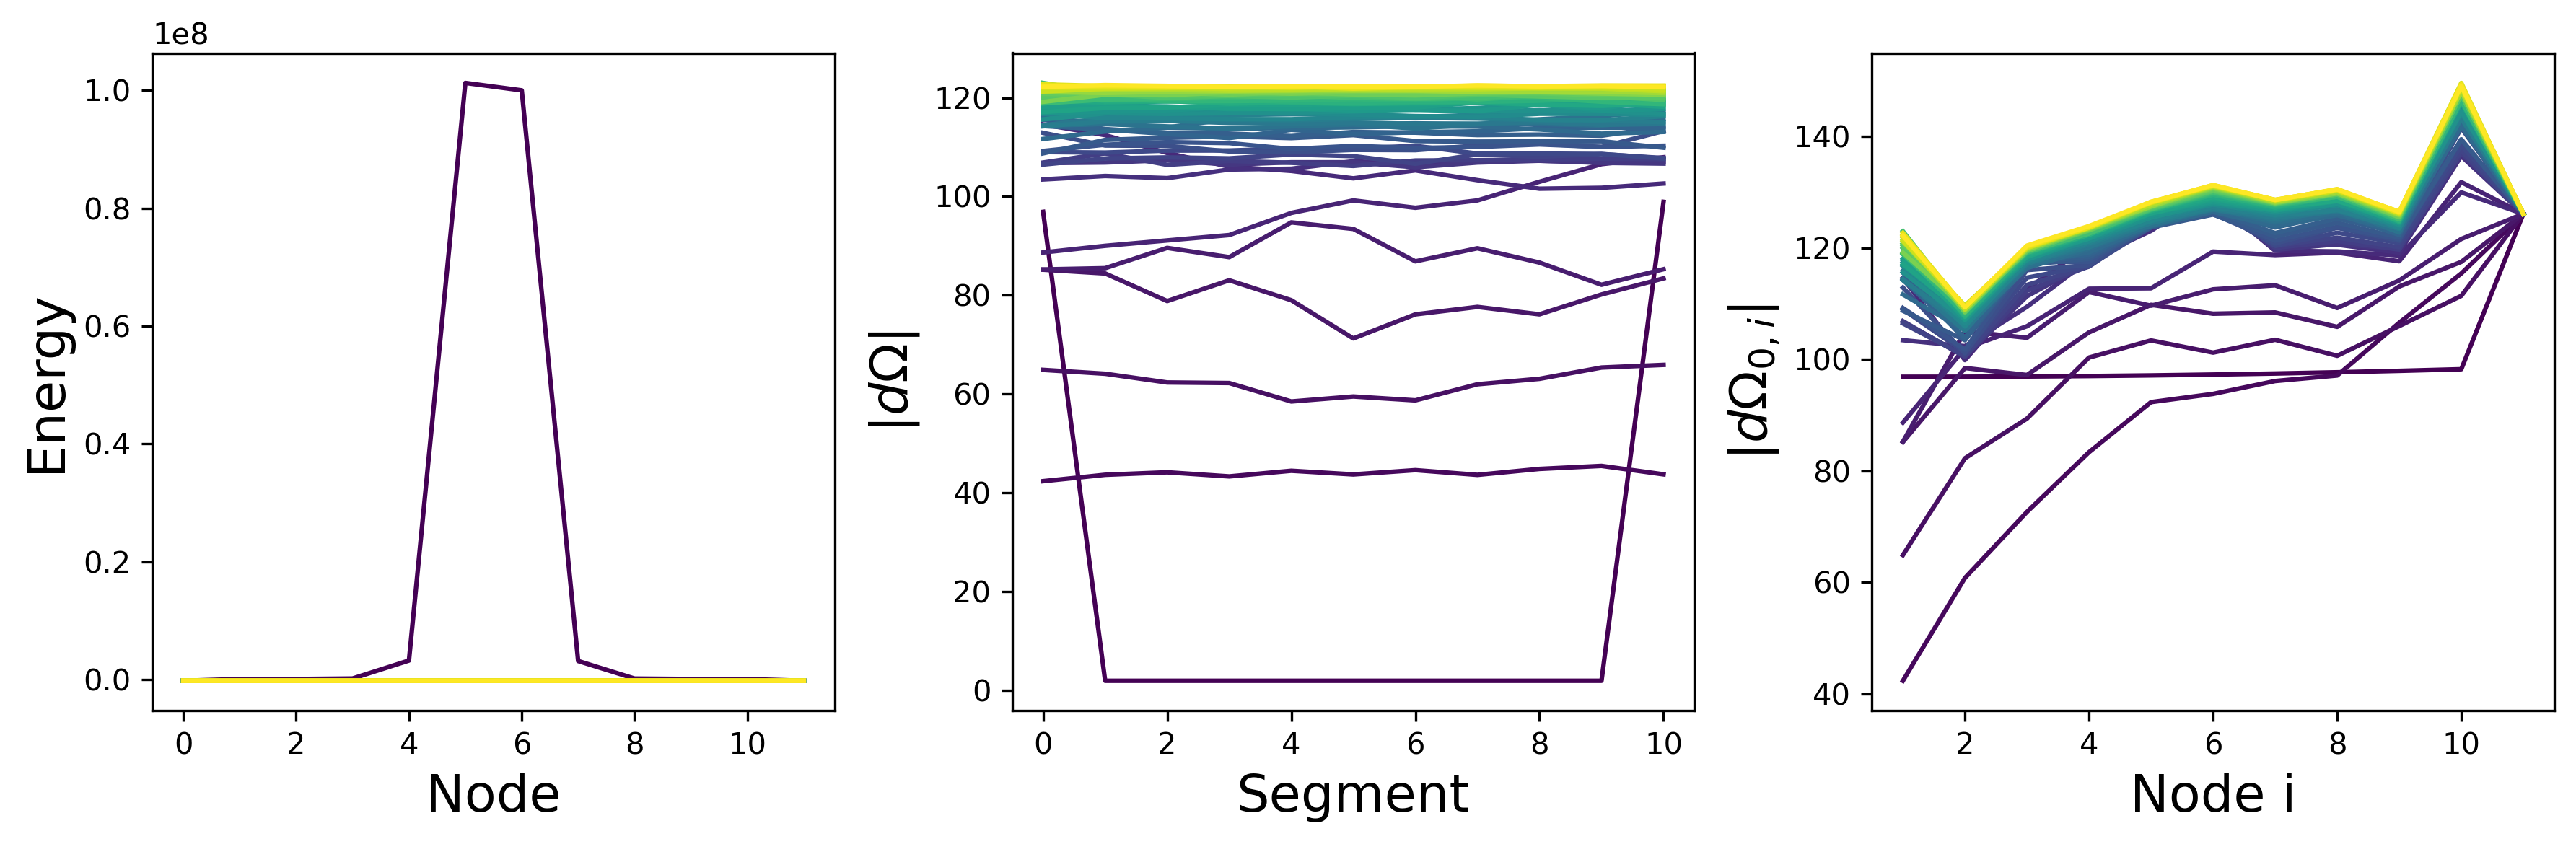

In [13]:
cmap = cm.viridis
runs = 50
norm = colors.Normalize(vmin=0, vmax=runs)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

energy = []
dists = []
other_dists = []
nodes = neb_driver.nodes
for i in range(len(nodes)-1):
    # print(len(sim.operations.integrator.forces))
    # sim.operations.integrator.reset()
    ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
    dists.append(ps_dist)
    energy.append(nodes[i].operations.integrator.forces[0].energy)
energy.append(nodes[-1].operations.integrator.forces[0].energy)

iter = list(range(1, len(nodes)))
for i in iter:
    ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
    other_dists.append(ps_dist)

axs[0].plot(energy, color=cmap(norm(0)))
axs[1].plot(dists, color=cmap(norm(0)))
axs[2].plot(iter, other_dists, color=cmap(norm(0)))

for j in range(1, runs+1):
    start = time.time()
    neb_driver.run(100)
    print(f"{j}:", time.time() - start)
    energy = []
    dists = []
    other_dists = []
    nodes = neb_driver.nodes
    for i in range(len(nodes)-1):
        # print(len(sim.operations.integrator.forces))
        # sim.operations.integrator.reset()
        ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
        dists.append(ps_dist)
        energy.append(nodes[i].operations.integrator.forces[0].energy)
    energy.append(nodes[-1].operations.integrator.forces[0].energy)

    iter = list(range(1, len(nodes)))
    for i in iter:
        ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
        other_dists.append(ps_dist)

    axs[0].plot(energy, color=cmap(norm(j)))
    axs[1].plot(dists, color=cmap(norm(j)))
    axs[2].plot(iter, other_dists, color=cmap(norm(j)))
axs[0].set_ylabel("Energy")
axs[0].set_xlabel("Node")
axs[1].set_ylabel(r"$|d\Omega|$")
axs[1].set_xlabel("Segment")
axs[2].set_ylabel(r"$|d\Omega_{0,i}|$")
axs[2].set_xlabel("Node i")

1: 6.5076210498809814
2: 6.667555332183838
3: 6.652410507202148
4: 6.648374080657959
5: 4.551817417144775
6: 5.513613700866699
7: 6.335599660873413
8: 5.59047794342041
9: 5.433711051940918
10: 6.463389873504639


Text(0.5, 0, 'Node i')

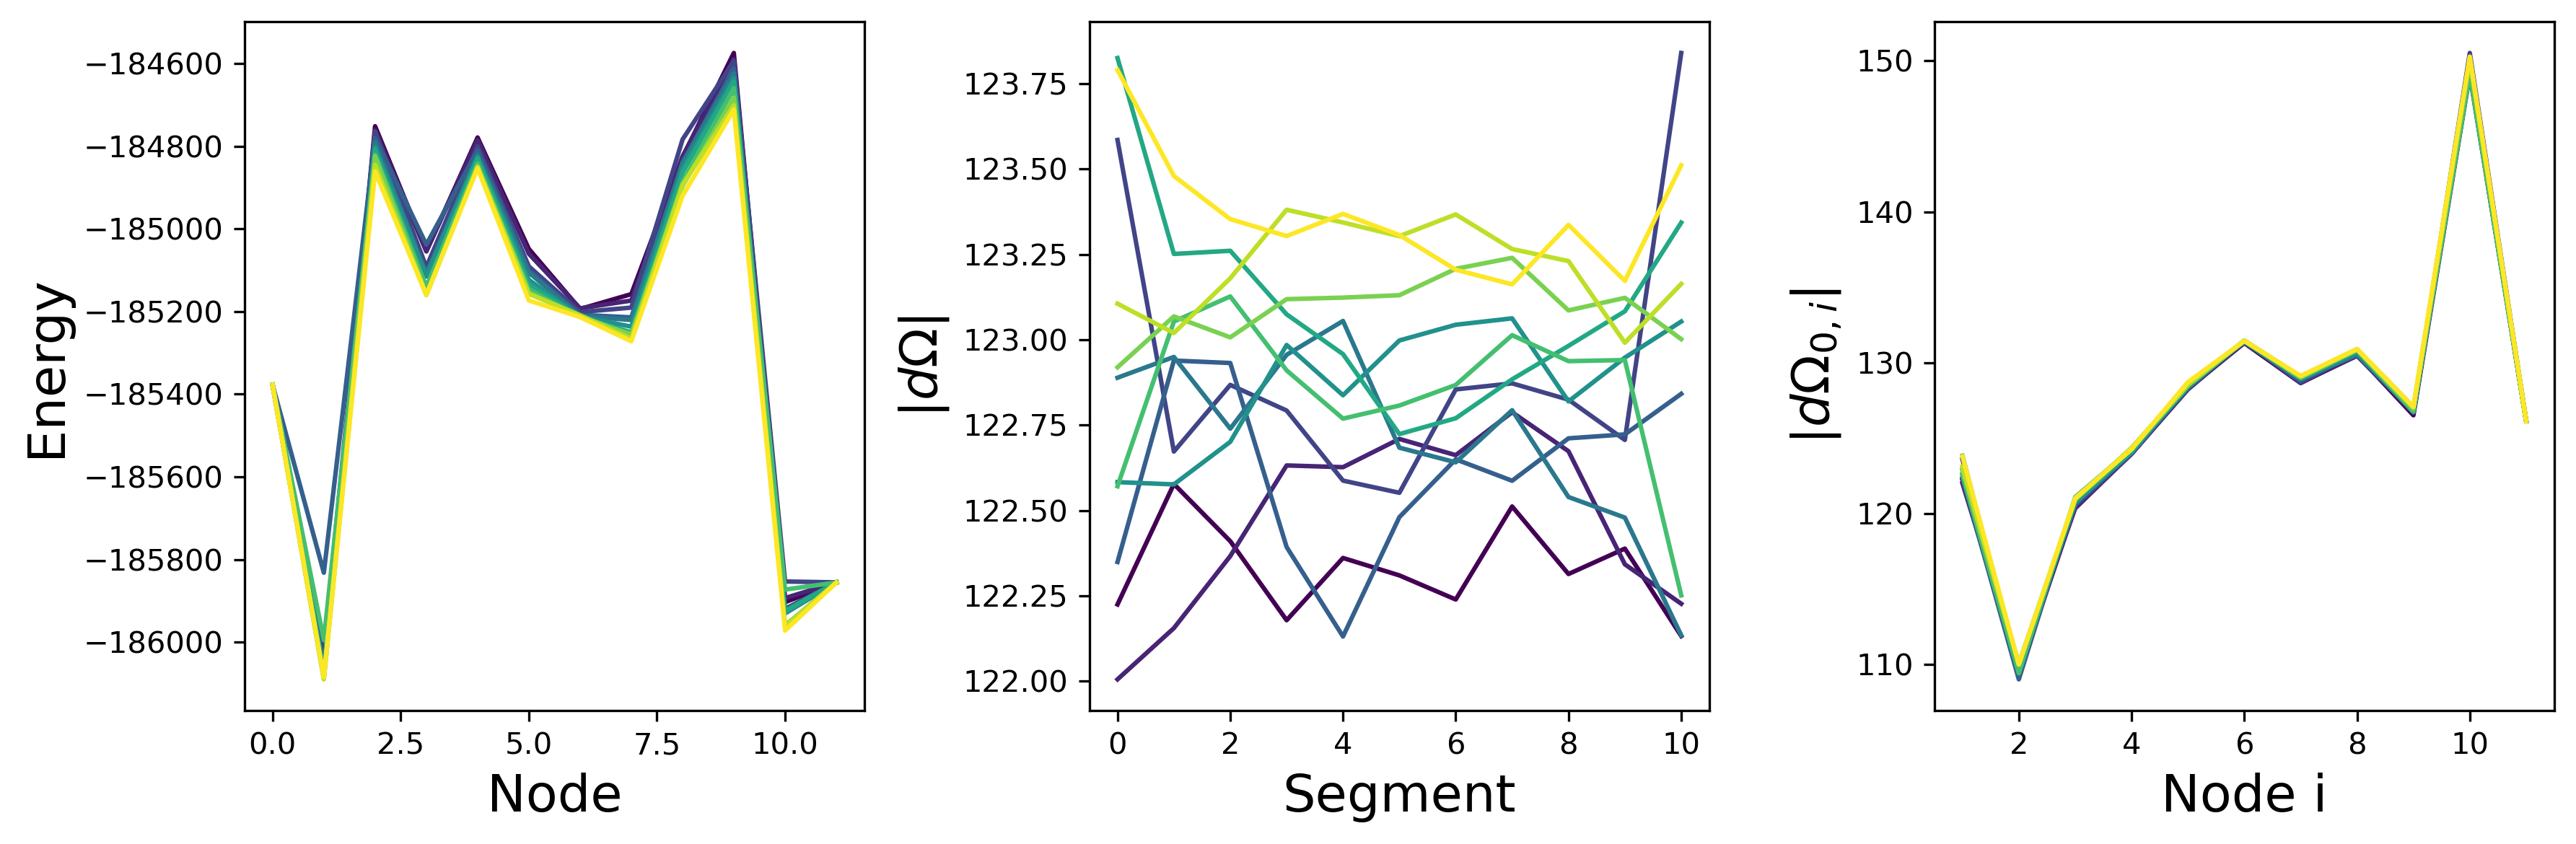

In [14]:
cmap = cm.viridis
runs = 10
norm = colors.Normalize(vmin=0, vmax=runs)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

energy = []
dists = []
other_dists = []
nodes = neb_driver.nodes
for i in range(len(nodes)-1):
    # print(len(sim.operations.integrator.forces))
    # sim.operations.integrator.reset()
    ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
    dists.append(ps_dist)
    energy.append(nodes[i].operations.integrator.forces[0].energy)
energy.append(nodes[-1].operations.integrator.forces[0].energy)

iter = list(range(1, len(nodes)))
for i in iter:
    ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
    other_dists.append(ps_dist)

axs[0].plot(energy, color=cmap(norm(0)))
axs[1].plot(dists, color=cmap(norm(0)))
axs[2].plot(iter, other_dists, color=cmap(norm(0)))

for j in range(1, runs+1):
    start = time.time()
    neb_driver.run(100)
    print(f"{j}:", time.time() - start)
    energy = []
    dists = []
    other_dists = []
    nodes = neb_driver.nodes
    for i in range(len(nodes)-1):
        # print(len(sim.operations.integrator.forces))
        # sim.operations.integrator.reset()
        ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
        dists.append(ps_dist)
        energy.append(nodes[i].operations.integrator.forces[0].energy)
    energy.append(nodes[-1].operations.integrator.forces[0].energy)

    iter = list(range(1, len(nodes)))
    for i in iter:
        ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
        other_dists.append(ps_dist)

    axs[0].plot(energy, color=cmap(norm(j)))
    axs[1].plot(dists, color=cmap(norm(j)))
    axs[2].plot(iter, other_dists, color=cmap(norm(j)))
axs[0].set_ylabel("Energy")
axs[0].set_xlabel("Node")
axs[1].set_ylabel(r"$|d\Omega|$")
axs[1].set_xlabel("Segment")
axs[2].set_ylabel(r"$|d\Omega_{0,i}|$")
axs[2].set_xlabel("Node i")